<a href="https://colab.research.google.com/github/Groxikm/ReferenseForSignApp/blob/main/Steps_n_splits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 50)

[Опис даних](https://search.r-project.org/CRAN/refmans/PPtreeregViz/html/insurance.html)

In [9]:
df = pd.read_parquet("val_predictions71.parquet")
df.describe()

,index,current_price,next_price,predicted_pos,predicted_lot
count,103564.000000,103564.000000,103564.000000,103564.000000,103564.0
mean,52381.500000,3110.123523,3110.187523,0.936175,1.0
std,29896.495976,173.091984,173.081255,0.988429,0.0
min,600.000000,2833.550000,2833.550000,0.000000,1.0
25%,26490.750000,2934.090000,2934.130000,0.000000,1.0
50%,52381.500000,3082.500000,3082.605000,0.000000,1.0
75%,78272.250000,3282.180000,3282.272500,2.000000,1.0
max,104163.000000,3498.530000,3498.530000,2.000000,1.0


In [ ]:
# prompt: add column "15min",  that will be same, as close price after 15 minutes (like 14 rows later form current)
TIMESTEP = 15
df['15min'] = df['close'].shift(-TIMESTEP)



In [ ]:
df

,timestamp,open,high,low,close,volume,15min
0,2023-11-26 23:01:00,2002.01,2002.01,2000.70,2000.84,106,2001.86
1,2023-11-26 23:02:00,2000.85,2001.32,2000.62,2001.16,130,2001.38
2,2023-11-26 23:03:00,2001.18,2001.75,2001.17,2001.18,100,2001.33
3,2023-11-26 23:04:00,2001.19,2001.23,2000.80,2001.22,91,2001.16
4,2023-11-26 23:05:00,2001.21,2001.22,2000.64,2000.67,55,2001.18
...,...,...,...,...,...,...,...
520841,2025-05-27 18:02:00,3301.90,3302.80,3301.87,3302.73,139,NaN
520842,2025-05-27 18:03:00,3302.74,3303.36,3302.74,3302.76,146,NaN
520843,2025-05-27 18:04:00,3302.76,3302.89,3301.98,3302.04,91,NaN
520844,2025-05-27 18:05:00,3302.08,3302.45,3301.83,3302.33,127,NaN


**MAIN GRAPH**

In [ ]:
df.isna().sum()
df.dropna(inplace=True)

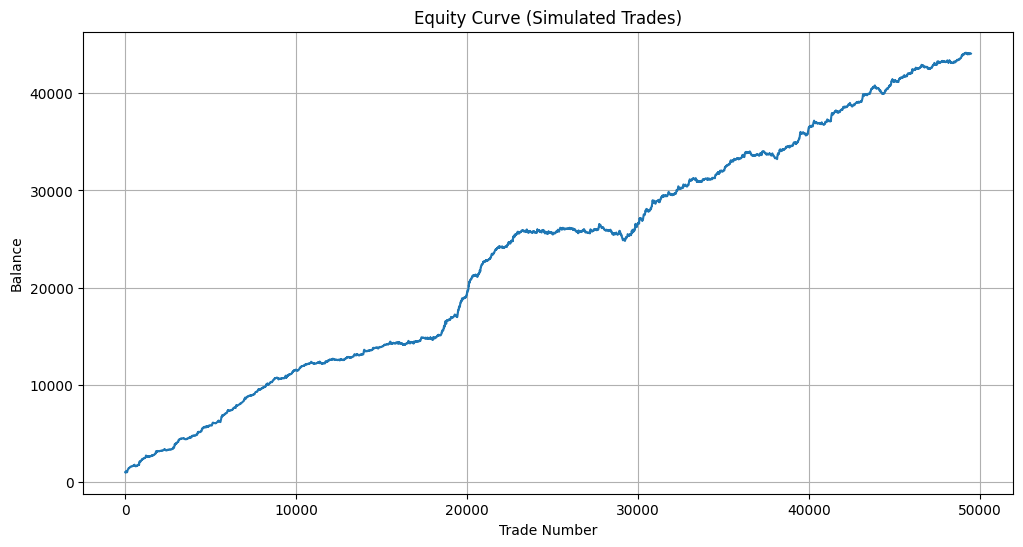

Final Balance: 44076.39
Total Trades Executed: 49458


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to your data file
PREDICTIONS_PATH = "val_predictions71.parquet"

# Define the initial balance
INITIAL_BALANCE = 1000.0

COMISSION_PER_SIDE = 0.00329 # considering spot = 3300 and 35$ comission per million $

# --- Load and Prepare Data ---
df = pd.read_parquet(PREDICTIONS_PATH)

# Filter out "HOLD" positions (predicted_pos == 0)
df_trades = df[df['predicted_pos'] != 0].copy()

# --- Calculate PnL and Equity Curve ---
balance = INITIAL_BALANCE
equity_curve = [balance]
trades = []

for idx, row in df_trades.iterrows():
    pos = row['predicted_pos']
    price_entry = row['current_price']
    price_exit = row['next_price']

    # Determine trade direction (1 for LONG, -1 for SHORT)
    direction = 1 if pos == 1 else -1

    # Calculate raw profit/loss
    # Using a simple model: volume is assumed to be 1 unit per trade
    pnl_raw = direction * (price_exit*(1-COMISSION_PER_SIDE) - price_entry*(1-COMISSION_PER_SIDE)) # / price_entry

    # Calculate net profit
    profit = pnl_raw

    # Update balance and equity curve
    balance += profit
    equity_curve.append(balance)

    # Store trade details (optional)
    trades.append({
        'index': row['index'],
        'pos': pos,
        'entry_price': price_entry,
        'exit_price': price_exit,
        'pnl': profit
    })

# --- Plot Equity Curve ---
plt.figure(figsize=(12, 6))
plt.plot(equity_curve)
plt.title("Equity Curve (Simulated Trades)")
plt.xlabel("Trade Number")  # X-axis represents the sequence of trades
plt.ylabel("Balance")
plt.grid(True)
plt.show()

# --- Display Metrics (Optional) ---
print(f"Final Balance: {balance:.2f}")
print(f"Total Trades Executed: {len(trades)}")

In [ ]:
# prompt: now, split out df int two separate pandas files - train and valid. Train must be 80% of data and valid - 20% (valid must have the most recent data)

# Ensure the dataframe is sorted by a time column if one exists
# Assuming your data is time-series based, sort by index or a dedicated time column
# If you have a dedicated time column, replace 'index' with that column name
df = df.sort_index()

# Calculate the split index
split_index = int(len(df) * 0.8)

# Split the dataframe
df_train = df.iloc[:split_index]
df_valid = df.iloc[split_index:]

df_train.to_parquet("train.parquet")
df_valid.to_parquet("valid.parquet")

print("Training set shape:", df_train.shape)
print("Validation set shape:", df_valid.shape)

Training set shape: (416664, 7)
Validation set shape: (104167, 7)


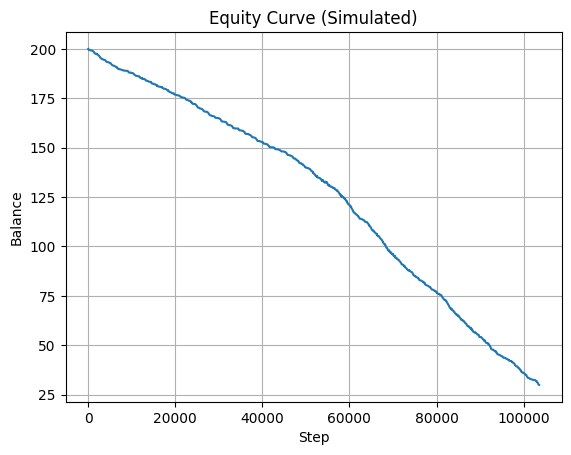

Final Balance: 29.91
Sharpe Ratio: -7.76
Max Drawdown: 85.05%
Trades Executed: 49458


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIG ===
PREDICTIONS_PATH = "val_predictions71.parquet"
INITIAL_BALANCE = 200.0
LEVERAGE = 1.0
LOT_UNIT = 1.0  # сколько денег мы тратим на один лот
COMMISSION = 0.001  # комиссия 0.1% на вход и выход

# === LOAD DATA ===
df = pd.read_parquet(PREDICTIONS_PATH)

balance = INITIAL_BALANCE
equity_curve = [balance]
trades = []

for idx, row in df.iterrows():
    pos = row['predicted_pos']
    lot = row['predicted_lot']
    price_entry = row['current_price']
    price_exit = row['next_price']

    if pos == 0:
        equity_curve.append(balance)
        continue

    direction = 1 if pos == 1 else -1
    volume = LOT_UNIT * (lot + 1) * LEVERAGE

    pnl_raw = direction * (price_exit - price_entry) * volume / price_entry
    cost = abs(volume) * COMMISSION * 2  # вход + выход комиссия

    profit = pnl_raw - cost
    balance += profit

    equity_curve.append(balance)
    trades.append({
        'index': row['index'],
        'pos': pos,
        'lot': lot,
        'entry_price': price_entry,
        'exit_price': price_exit,
        'volume': volume,
        'pnl': profit
    })

# === SAVE TRADES (OPTIONAL) ===
pd.DataFrame(trades).to_parquet("trade_log.parquet")

# === PLOT ===
plt.figure()
plt.plot(equity_curve)
plt.title("Equity Curve (Simulated)")
plt.xlabel("Step")
plt.ylabel("Balance")
plt.grid(True)
plt.savefig("equity_curve.png")
plt.show()

# === METRICS ===
import numpy as np

returns = pd.Series(equity_curve).pct_change().dropna()
sharpe = np.mean(returns) / np.std(returns) * (252**0.5) if np.std(returns) > 0 else 0
max_drawdown = 1 - pd.Series(equity_curve).div(pd.Series(equity_curve).cummax()).min()

print(f"Final Balance: {balance:.2f}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")
print(f"Trades Executed: {len(trades)}")


In [ ]:
# prompt: ok, now save new df1

df1.to_parquet("alldata_new.parquet")

In [ ]:
# prompt: now, split out df1 to two more parquets: train.parquet (85% of all data) and valid.parquet (rest). Valid must contain more recent data, then train

# Sort by timestamp to ensure recent data is at the end
df1 = df1.sort_values(by='timestamp').reset_index(drop=True)

# Calculate the split point
total_rows = len(df1)
train_size = int(total_rows * 0.85)

# Split the data
train_df = df1.iloc[:train_size]
valid_df = df1.iloc[train_size:]

# Save to parquet files
train_df.to_parquet("train.parquet")
valid_df.to_parquet("valid.parquet")

print(f"Train data saved to train.parquet with {len(train_df)} rows.")
print(f"Validation data saved to valid.parquet with {len(valid_df)} rows.")


Train data saved to train.parquet with 454241 rows.
Validation data saved to valid.parquet with 80161 rows.


In [ ]:
dfd = pd.read_parquet("train.parquet")
dfd = dfd.iloc[:10000]
train_dfd = dfd.iloc[:8000]
valid_dfd = dfd.iloc[8000:]
train_dfd.to_parquet("dtrain.parquet")
valid_dfd.to_parquet("dvalid.parquet")
print(f"Train data saved to dtrain.parquet with {len(train_dfd)} rows.")
print(f"Validation data saved to dvalid.parquet with {len(valid_dfd)} rows.")
print(f"Total dfd {len(dfd)} rows.")

Train data saved to dtrain.parquet with 8000 rows.
Validation data saved to dvalid.parquet with 2000 rows.
Total dfd 10000 rows.


# Завдання 1
Виведіть основні числові характеристики та кількість пропущених значень по стовпчиках

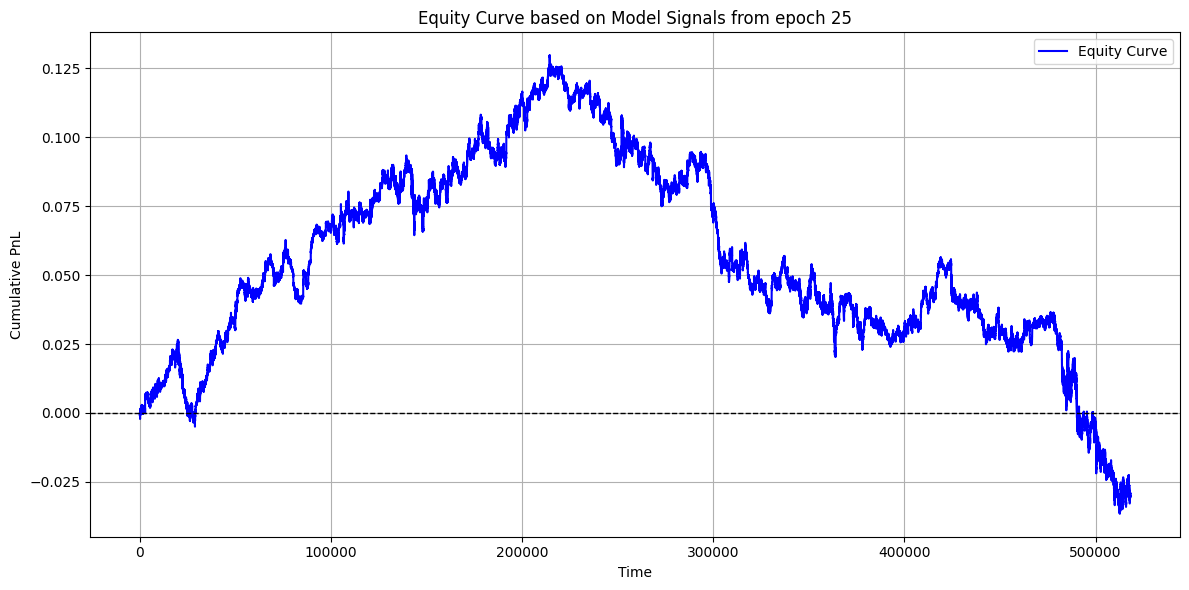

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Параметры ===
market_data_path = "/content/gold_prices.parquet"
signal_path = "/content/signals_epoch_50.parquet"

# === 1. Загружаем данные ===
df = pd.read_parquet(market_data_path)
signals = pd.read_parquet(signal_path)['signal'].values

# === 2. Обрабатываем данные так же, как при обучении ===
df['r_close'] = df['close'].pct_change().fillna(0)
df['log_vol_delta'] = np.log(df['volume'].replace(0, np.nan)).diff().fillna(0)
df['close_return'] = df['r_close'].shift(-1)
df.dropna(inplace=True)

# Учитываем сдвиг, связанный с SEQUENCE_LENGTH
SEQUENCE_LENGTH = 60
df = df.iloc[SEQUENCE_LENGTH:]  # отбрасываем первые 60 строк

# === 3. Берём столько же строк, сколько у нас сигналов ===
df = df.iloc[:len(signals)]
df = df.copy()
df['signal'] = signals

# === 4. Вычисляем P&L ===
SIGNAL_THRESHOLD = 0.01  # или 0.02, поэкспериментируй

# Применим фильтр
filtered_signal = df['signal'].copy()
filtered_signal[np.abs(filtered_signal) < SIGNAL_THRESHOLD] = 0.0

df['signal_filtered'] = filtered_signal
df['pnl'] = df['signal_filtered'] * df['close_return']

df['equity'] = df['pnl'].cumsum()

# === 5. Строим ===
plt.figure(figsize=(12, 6))
plt.plot(df['equity'], label="Equity Curve", color="blue")
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.title("Equity Curve based on Model Signals from epoch 25")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# === 1. Total Return ===
total_return = df['equity'].iloc[-1]
print(f"Total Return: {total_return:.4%}")

# === 2. Sharpe Ratio ===
# Предполагаем, что PnL — по минутке. Приводим к годовой шкале
# 252 торговых дня * 24 часа * 60 минут ≈ 362_880 минут
mean_return = df['pnl'].mean()
std_return = df['pnl'].std()
sharpe = (mean_return / std_return) * np.sqrt(362880) if std_return != 0 else 0
print(f"Sharpe Ratio (annualized): {sharpe:.2f}")

# === 3. Max Drawdown ===
roll_max = df['equity'].cummax()
drawdown = df['equity'] - roll_max
max_drawdown = drawdown.min()
print(f"Max Drawdown: {max_drawdown:.4%}")

# === 4. Volatility ===
volatility = std_return * np.sqrt(362880)
print(f"Volatility (annualized): {volatility:.2%}")

# === 5. Win Ratio ===
win_ratio = (df['pnl'] > 0).sum() / len(df)
print(f"Win Ratio: {win_ratio:.2%}")


Total Return: -2.9160%
Sharpe Ratio (annualized): -0.26
Max Drawdown: -16.6308%
Volatility (annualized): 7.95%
Win Ratio: 49.28%


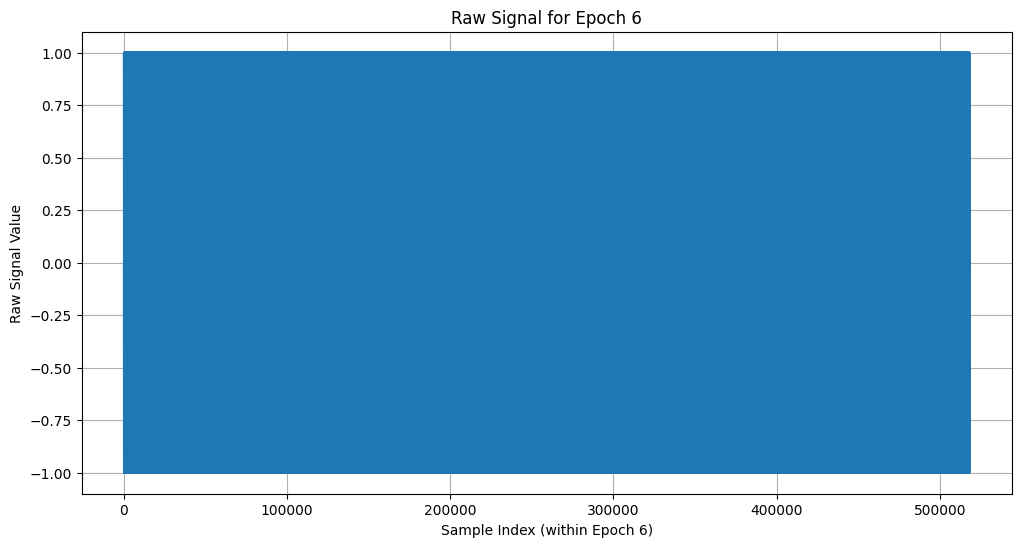

In [ ]:
# prompt: create linear plot for raw_signal for only epoch 1.

# Filter the DataFrame for epoch 1
df_epoch_1 = df[df['epoch'] == 6]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df['signal'])
plt.xlabel('Sample Index (within Epoch 6)')
plt.ylabel('Raw Signal Value')
plt.title('Raw Signal for Epoch 6')
plt.grid(True)
plt.show()

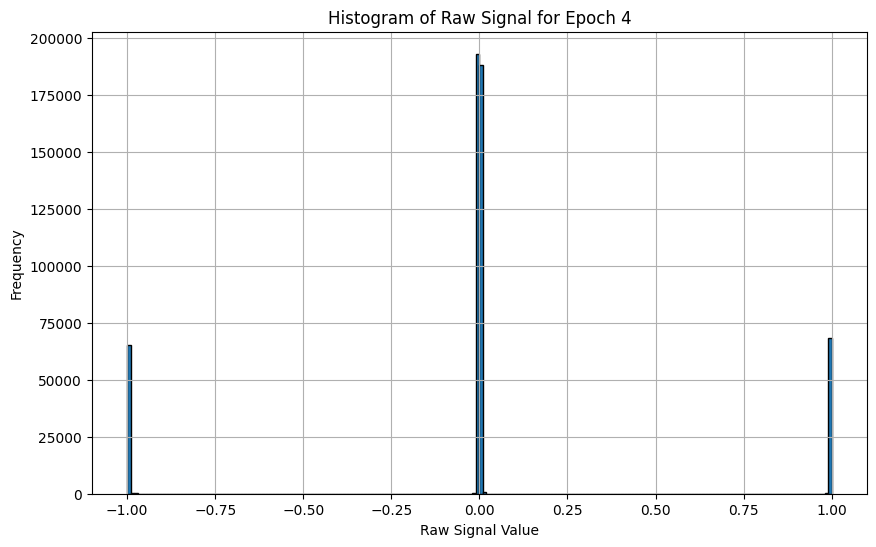

In [ ]:
# prompt: create histogram quanity plot for raw_signal for only epoch 1

plt.figure(figsize=(10, 6))
plt.hist(df['signal'], bins = 200, edgecolor='black')
plt.xlabel('Raw Signal Value')
plt.ylabel('Frequency')
plt.title('Histogram of Raw Signal for Epoch 4')
plt.grid(True)
plt.show()

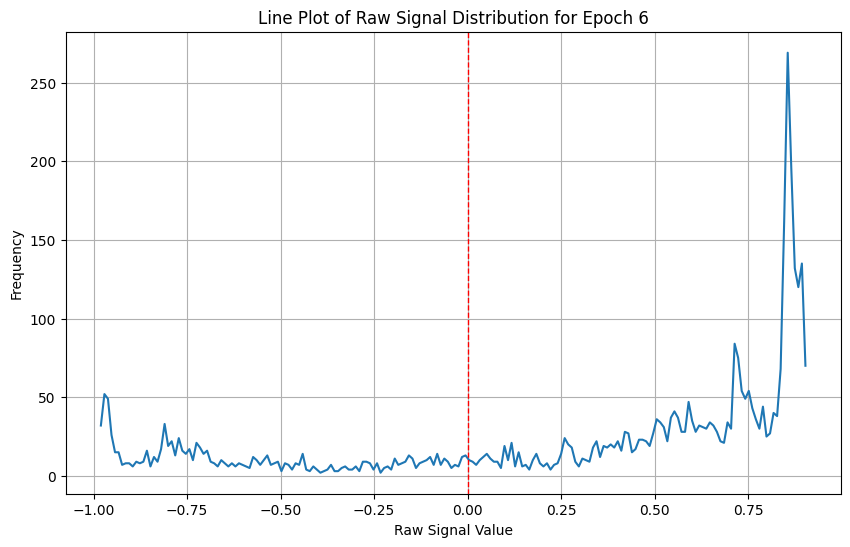

In [ ]:
# prompt: look previous histogram code and now generate plot, that will do same, but not with bars - only line, that goes from bar's top to another. Without points - pure line and vertical line in zero

# Calculate the histogram data
hist, bin_edges = np.histogram(df_epoch_1['raw_signal'], bins=200)

# Calculate the centers of the bins
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure(figsize=(10, 6))
# Plot the line graph
plt.plot(bin_centers, hist)

# Add a vertical line at x=0
plt.axvline(x=0, color='r', linestyle='--', linewidth=1)

plt.xlabel('Raw Signal Value')
plt.ylabel('Frequency')
plt.title('Line Plot of Raw Signal Distribution for Epoch 6')
plt.grid(True)
plt.show()


<ipython-input-18-02be6dee99fb>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


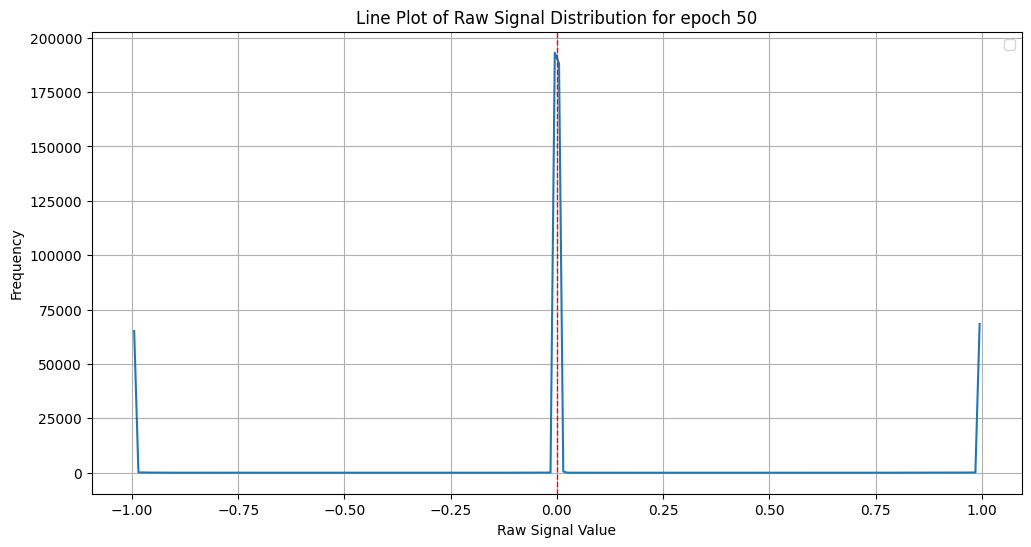

In [ ]:
# prompt: ok, now make same graph as last one (quantity histogram, but with lines), but combine all 6 epochs in one plot - just draw their lines with different colors

plt.figure(figsize=(12, 6))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

hist, bin_edges = np.histogram(df['signal'], bins=200)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, hist)

plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
plt.xlabel('Raw Signal Value')
plt.ylabel('Frequency')
plt.title('Line Plot of Raw Signal Distribution for epoch 50')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
df.isna().sum()

,0
age,0
bmi,0
children,0
expenses,0


# Завдання 2
Розділіть дані на залежну y(`expenses`) та незалежну X ознаки. Розділіть дані на тренувальну та тестову частини

In [ ]:
df.corr(method = 'pearson')

,age,bmi,children,expenses
age,1.000000,0.109341,0.042469,0.299008
bmi,0.109341,1.000000,0.012645,0.198576
children,0.042469,0.012645,1.000000,0.067998
expenses,0.299008,0.198576,0.067998,1.000000


<Axes: xlabel='age', ylabel='expenses'>

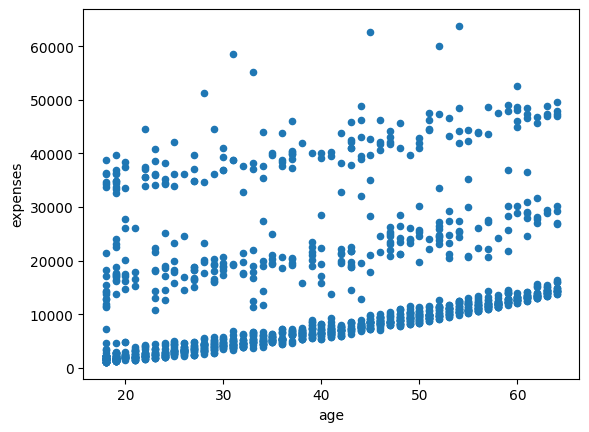

In [ ]:
df.plot.scatter(x='age', y='expenses')

In [ ]:
y = df['expenses']
X = df.drop('expenses',axis =1)
X = X.drop('children',axis =1)
X = X.drop('bmi',axis =1)


In [ ]:
y

,expenses
0,16884.92
1,1725.55
2,4449.46
3,21984.47
4,3866.86
...,...
1333,10600.55
1334,2205.98
1335,1629.83
1336,2007.95


In [ ]:
X

,age
0,19
1,18
2,28
3,33
4,32
...,...
1333,50
1334,18
1335,18
1336,21


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
X_train

,age
560,46
1285,47
1142,52
969,39
486,54
...,...
1095,18
1130,39
1294,58
860,37


# Завдання 3
Натренуйте модель та виведіть такі метрики: MAE, RMSE, R2

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
model.coef_

array([240.59656289])

In [ ]:
model.intercept_

3876.9286950300375

In [ ]:
from sklearn import metrics

def get_metrics(y_true, y_pred, name = "model" ):
  df = pd.DataFrame()
  df.loc["MAE",name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["MSE",name] = metrics.mean_squared_error(y_true, y_pred)
  df.loc["RMSE",name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2",name] = metrics.r2_score(y_true, y_pred)
  return df.round(2)

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([14703.77402497, 12538.40495898, 19275.10871983, 14944.37058785,
        8448.26338989, 12057.2118332 ,  8448.26338989, 19275.10871983,
       10613.63245588, 15666.16027652, 11094.82558165, 13741.38777342,
       10854.22901877, 14944.37058785, 18312.72246828, 15184.96715074,
       15666.16027652, 15184.96715074, 14944.37058785, 14222.58089919,
        9891.84276722, 14222.58089919,  8448.26338989,  9170.05307855,
       15906.7568394 , 16869.14309095, 18312.72246828, 10373.03589299,
       15184.96715074,  8207.666827  , 13500.79121053, 17590.93277962,
        8929.45651567, 11094.82558165, 10132.4393301 , 14703.77402497,
        8929.45651567, 14222.58089919, 16387.94996518, 12538.40495898,
        8448.26338989,  9170.05307855, 17350.33621673, 18072.12590539,
       11816.61527032, 18072.12590539,  8929.45651567,  9891.84276722,
       14222.58089919, 11335.42214454, 19034.51215694,  8207.666827  ,
       13500.79121053,  8207.666827  , 17350.33621673, 15906.7568394 ,
      

In [ ]:
y_train

,expenses
560,9193.84
1285,8534.67
1142,27117.99
969,8596.83
486,12475.35
...,...
1095,4561.19
1130,8582.30
1294,11931.13
860,46113.51


In [ ]:
all_metrics = pd.DataFrame()
all_metrics['train'] = get_metrics(y_train, model.predict(X_train))
all_metrics['test'] = get_metrics(y_test, y_pred)
all_metrics = all_metrics.applymap(lambda x: round(x / 10, 2))
all_metrics

<ipython-input-171-c558eb55f6f1>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_metrics = all_metrics.applymap(lambda x: round(x / 10, 2))


,train,test
MAE,890.34,884.35
MSE,13458106.77,13459559.84
RMSE,1160.09,1160.15
R2,0.01,0.01


Якось не дуже xD. Я вибрав стовпчики з найбільшою корреляцією 0.3. Може щось десь наплутав. R2 виглядає дуже погано, хоча інші метрики хороші

# Завдання 4
Напишіть рівняння регресії за прикладом:
Ціна = 1.02*Температура - 15.6

In [ ]:
#expences = 240.597 * age + 3876.929

# Завдання 5 (оптимально)
Перевірте як видалення викидів вплине на результат. Розгляньте один з варіантів:
* видалення викидів по стовпчику `expenses`
* видалення викидів по всіх стовпчиків

<Axes: xlabel='age', ylabel='expenses'>

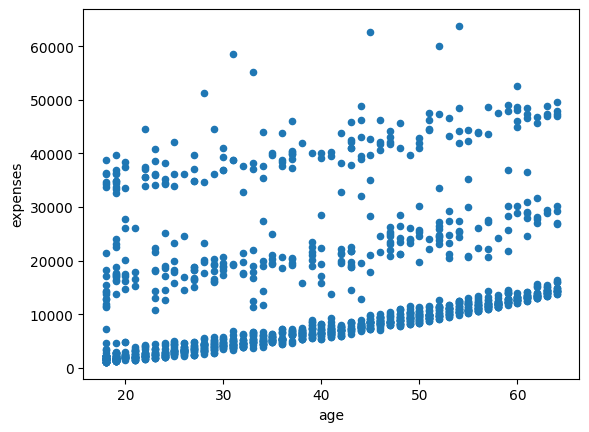

In [ ]:
df.plot.scatter(x='age', y='expenses')

<Axes: >

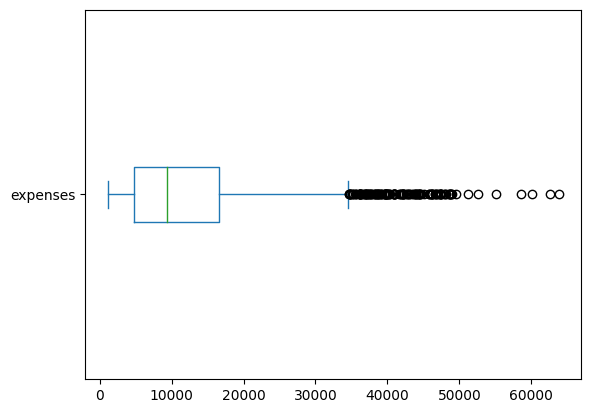

In [ ]:
df.plot.box(column='expenses',vert = False)

<Axes: >

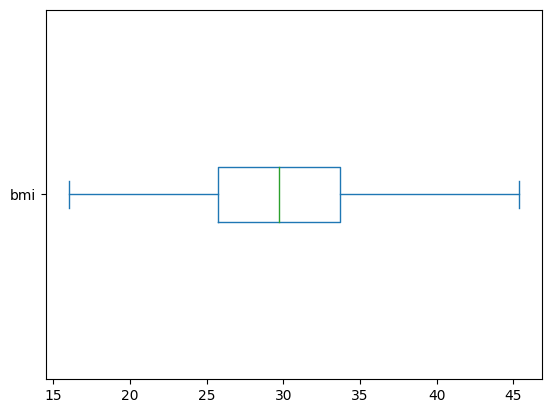

In [ ]:
df.plot.box(column='bmi',vert = False)

In [ ]:
q1 = df['expenses'].quantile(0.25)
q3 = df['expenses'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr

df = df[(df['expenses'] > lower) & (df['expenses'] < upper)]

In [ ]:
q1 = df['bmi'].quantile(0.25)
q3 = df['bmi'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr

df = df[(df['bmi'] > lower) & (df['bmi'] < upper)]

<Axes: >

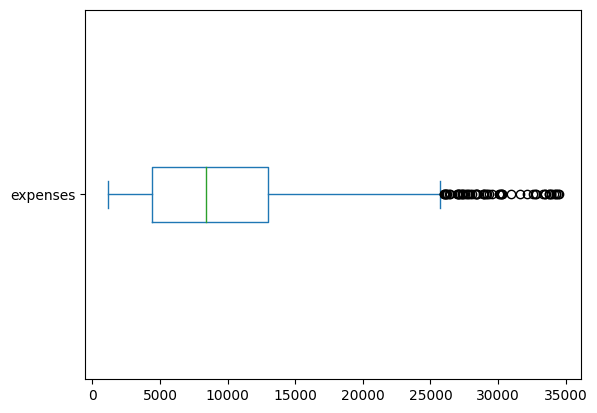

In [ ]:
df.plot.box(column='expenses',vert = False)

<Axes: >

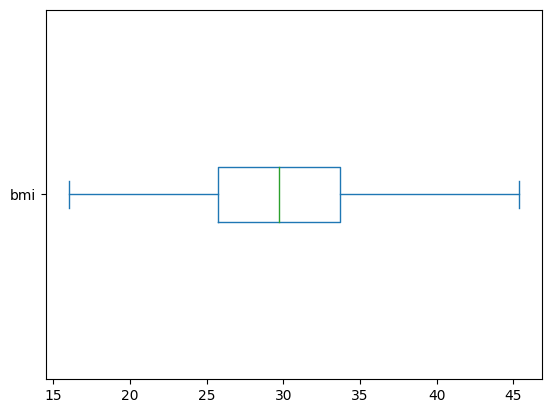

In [ ]:
df.plot.box(column='bmi',vert = False)

In [ ]:
df.corr(method = 'pearson')

,age,bmi,children,expenses
age,1.000000,0.124802,0.038125,0.435942
bmi,0.124802,1.000000,-0.010185,-0.056684
children,0.038125,-0.010185,1.000000,0.084167
expenses,0.435942,-0.056684,0.084167,1.000000


По корреляції витрат і віку трохи краще. вже майже 0.45

In [ ]:
y = df['expenses']
X = df.drop('expenses',axis =1)
X = X.drop('children',axis =1)
X = X.drop('bmi',axis =1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [ ]:
y_pred = model.predict(X_test)
y_pred

array([15666.16027652,  8929.45651567,  8207.666827  , 11094.82558165,
       13741.38777342, 14703.77402497,  8207.666827  , 15425.56371363,
        8207.666827  , 14463.17746208,  9651.24620433, 14222.58089919,
       15184.96715074,  8929.45651567,  9170.05307855, 17350.33621673,
       16387.94996518, 17350.33621673, 13260.19464764, 17831.5293425 ,
       17109.73965384, 17590.93277962, 18312.72246828, 13981.9843363 ,
       16628.54652807, 18312.72246828, 12538.40495898, 15906.7568394 ,
       12538.40495898, 15666.16027652,  9170.05307855, 10613.63245588,
       11094.82558165, 18793.91559405, 13260.19464764, 19034.51215694,
        8207.666827  , 14944.37058785, 19275.10871983,  8207.666827  ,
       17590.93277962, 11335.42214454, 10854.22901877, 16869.14309095,
        9170.05307855, 14222.58089919, 17109.73965384, 14703.77402497,
       14703.77402497, 11576.01870743, 16147.35340229, 14463.17746208,
       15425.56371363, 17831.5293425 , 18072.12590539, 18553.31903117,
      

In [ ]:
all_metrics = pd.DataFrame()
all_metrics['train'] = get_metrics(y_train, model.predict(X_train))
all_metrics['test'] = get_metrics(y_test, y_pred)
all_metrics = all_metrics.applymap(lambda x: round(x / 10, 2))
all_metrics

<ipython-input-207-c558eb55f6f1>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_metrics = all_metrics.applymap(lambda x: round(x / 10, 2))


,train,test
MAE,681.73,692.85
MSE,5294992.11,5633599.43
RMSE,727.67,750.57
R2,-0.00,-0.00


Диво дивне XD